In [32]:
from torchvision import datasets, transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(0)

### Data handler

In [33]:
# Define a transformation to normalize the dataset
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                                ])
                                

# Download and load the training data
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

### Model

In [34]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 458)
        self.fc2 = nn.Linear(458, 246)
        self.fc3 = nn.Linear(246, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with a 0.2 drop probability 
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.shape[0], -1)    
        # Set the activation functions
        layer1 = self.dropout(F.relu(self.fc1(x)))
        layer2 = self.dropout(F.relu(self.fc2(layer1)))
        layer3 = self.dropout(F.relu(self.fc3(layer2)))
        layer4 = self.dropout(F.relu(self.fc4(layer3)))
        
        out = self.fc5(layer4)
    
        return out
    
model = Network()
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

### Forward pass

In [35]:
def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize =(6, 9), ncols =2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

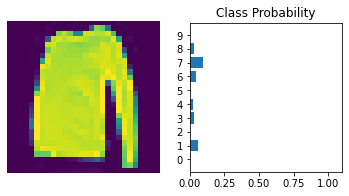

In [36]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])                          # ps is probablity

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

### Training the network

In [37]:
epochs = 100


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.80


for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    
    running_accuracy = 0
    running_loss = 0

    # training
    for x_train_batch, y_train_batch in trainloader:

        optimizer.zero_grad()

        # forward pass
        logits = model(x_train_batch)
        train_preds = torch.argmax(logits.detach(), dim=1)

        # loss
        train_loss = criterion(logits, y_train_batch)
        running_loss += train_loss.item()

        # train accuracy
        train_acc = (y_train_batch == train_preds).sum() / len(y_train_batch)
        running_accuracy += train_acc.item()

        # backward pass
        train_loss.backward()

        # update paramaters
        optimizer.step()

    # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss / len(trainloader))
    
    # mean accuracies
    train_accuracies.append(running_accuracy / len(trainloader))
    
    # print
    print(f'Train loss: {train_losses[-1] :.3f}')

    # validation
    model.eval()

    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0

        for x_test_batch, y_test_batch in testloader:
            
            # logits
            test_logits = model(x_test_batch)

            # predictions
            test_preds = torch.argmax(test_logits, dim=1)
            
            # accuracy
            test_acc = (y_test_batch == test_preds).sum() / len(y_test_batch)
            running_accuracy += test_acc.item()

            # loss
            test_loss = criterion(test_logits, y_test_batch)
            running_loss += test_loss.item()

        # mean accuracy for each epoch
        test_accuracies.append(running_accuracy / len(testloader))

        # mean loss for each epoch
        test_losses.append(running_accuracy / len(testloader))

         # print
        print(f'Test loss: {test_losses[-1] :.3f}')
        print(f'Test accuracy: {test_accuracies[-1]*100 :.2f}%')
        print('='*100)

        # saving best model
        # is current mean score (mean per epoch) greater than or equal to the benchmark?
        if test_accuracies[-1] > benchmark_accuracy:

            # save model 
            torch.save(model.state_dict(), './model.pth')

            # update benckmark
            benchmark_accuracy = test_accuracies[-1]

    model.train()


# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.axhline(benchmark_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({benchmark_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./learning_curve.png', dpi = 200)

plt.show()

Epoch 1/100
Train loss: 0.613
Test loss: 0.837
Test accuracy: 83.74%
Epoch 2/100
Train loss: 0.444
Test loss: 0.846
Test accuracy: 84.56%
Epoch 3/100
Train loss: 0.403
Test loss: 0.857
Test accuracy: 85.72%
Epoch 4/100
Train loss: 0.378
Test loss: 0.856
Test accuracy: 85.61%
Epoch 5/100
Train loss: 0.359
Test loss: 0.873
Test accuracy: 87.28%
Epoch 6/100
Train loss: 0.346
Test loss: 0.865
Test accuracy: 86.51%
Epoch 7/100
Train loss: 0.333
Test loss: 0.874
Test accuracy: 87.44%
Epoch 8/100
Train loss: 0.323
Test loss: 0.874
Test accuracy: 87.37%
Epoch 9/100
Train loss: 0.314
Test loss: 0.877
Test accuracy: 87.70%
Epoch 10/100
Train loss: 0.305
Test loss: 0.881
Test accuracy: 88.14%
Epoch 11/100
Train loss: 0.297
Test loss: 0.880
Test accuracy: 87.96%
Epoch 12/100
Train loss: 0.293
Test loss: 0.879
Test accuracy: 87.95%
Epoch 13/100
Train loss: 0.289
Test loss: 0.868
Test accuracy: 86.75%
Epoch 14/100
Train loss: 0.277
Test loss: 0.886
Test accuracy: 88.55%
Epoch 15/100
Train loss: 0.27

### Save and Load

In [ ]:
torch.save(model.state_dict(), 'checkpoint1.pth')

In [ ]:
state_dict = torch.load('checkpoint1.pth')
print(state_dict.keys())

### Testing